# ak_utils

In [42]:
# ashok added code 
import cv2

def read_image(image_path):
    """
    Read image from image_path in RGB format
    image: [H, W, 3]
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

import matplotlib.pyplot as plt
import torch

def lazy_plot(image,gray=False,figsize=(2.5,2.5),centered=False):

    """
    expected usage:
    image is np_array or a tensor

    Plot image
    image: [H, W, 3]
    if tensor: image: [3, H, W]
    """
    # if centered i.e. b/w [-1,+1] make it [0,1]
    if centered:
      image = (image+1)/2
    # 1.check if tensor
    if isinstance(image,torch.Tensor) :
        image = image.detach().cpu().numpy()
    # 2. batch
    if len(image.shape) == 4:
        N = image.shape[0]
        if N != 1:
            print("Plotting only the first image in the batch")
        image = image[0]
    # 3. channel
    first_channel = image.shape[0]
    if first_channel in [3, 1, 4]:
        image = image.transpose(1,2,0)
    # 4. check the range of the image
    if image.max() > 1 + 1e-3:
        image = image / 255.0
    # 5. plot
    plt.figure(figsize=figsize)
    if gray:
        plt.imshow(image,cmap='gray')
    else:
        plt.imshow(image)
    plt.axis('off')

# functions

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import PIL.Image
import scipy
import scipy.ndimage
import dlib

In [44]:
def get_landmark(filepath, predictor):
    """get landmark with dlib
    :return: np.array shape=(68, 2)
    """
    detector = dlib.get_frontal_face_detector()

    img = dlib.load_rgb_image(filepath)
    dets = detector(img, 1)

    for k, d in enumerate(dets):
        shape = predictor(img, d)

    t = list(shape.parts())
    a = []
    for tt in t:
        a.append([tt.x, tt.y])
    lm = np.array(a)
    return lm

In [60]:
def align_face(filepath, predictor, output_size,enable_padding = True):
    """
    :param filepath: str
    :return: PIL Image
    """

    lm = get_landmark(filepath, predictor)

    lm_chin = lm[0: 17]  # left-right
    lm_eyebrow_left = lm[17: 22]  # left-right
    lm_eyebrow_right = lm[22: 27]  # left-right
    lm_nose = lm[27: 31]  # top-down
    lm_nostrils = lm[31: 36]  # top-down
    lm_eye_left = lm[36: 42]  # left-clockwise
    lm_eye_right = lm[42: 48]  # left-clockwise
    lm_mouth_outer = lm[48: 60]  # left-clockwise
    lm_mouth_inner = lm[60: 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left = np.mean(lm_eye_left, axis=0)
    eye_right = np.mean(lm_eye_right, axis=0)
    eye_avg = (eye_left + eye_right) * 0.5
    eye_to_eye = eye_right - eye_left
    mouth_left = lm_mouth_outer[0]
    mouth_right = lm_mouth_outer[6]
    mouth_avg = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1

    # here we got x,y,c
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2
    # got : quad, qsize

    
    # read image
    img = PIL.Image.open(filepath)

    transform_size = output_size
    # enable_padding = True

    print('original', img.size)
    img_list = []
    img_list.append(img)
    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, PIL.Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink
        
    # to invert bakc to original size
    # img = img.resize((int(np.rint(float(img.size[0]) * shrink)), int(np.rint(float(img.size[1]) * shrink))), PIL.Image.ANTIALIAS)
    print('after shrink; inverted back', img.size)

    print('after shrink', img.size)
    
    
    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
            int(np.ceil(max(quad[:, 1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]),
            min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]

    print('crop',img.size,'\n',crop)
    img_list.append(img)

    # Pad.
    pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
           int(np.ceil(max(quad[:, 1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0),
           max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w - 1 - x) / pad[2]),
                          1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h - 1 - y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        quad += pad[:2]

    print('pad', pad, '\n after padding', img.size)
    img_list.append(img)

    # Transform.
    img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    print('transformation', PIL.Image.QUAD, (quad + 0.5).flatten())
    if output_size < transform_size:
        img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

    img_list.append(img)
    quad_return = (quad + 0.5)
    print('final img size', img.size)
    # Return aligned image.
    return img, crop, pad, img_list, quad_return

In [46]:
from PIL import Image, ImageDraw

def draw_bounding_box(img, coordinates):
    #img = Image.open(image_path)

    draw = ImageDraw.Draw(img)

    x1, y1 = coordinates[0]
    x2, y2 = coordinates[1]
    x3, y3 = coordinates[2]
    x4, y4 = coordinates[3]

    draw.polygon([(x1, y1), (x2, y2), (x3, y3), (x4, y4)], outline="yellow")

    img.show()

#draw_bounding_box(img_test_path, output_pts)

In [47]:
def reverse_transform(full_image_path, crop_image_path, crop):
    
    crop_img = Image.open(crop_image_path)
    full_image = cv2.imread(full_image_path)

    org_size = full_img.shape
    crop_size = crop_img.size

    #pil_image = PIL.Image.open(crop_size).convert('RGB')
    crop_img = np.array(crop_img)
    # Convert RGB to BGR
    crop_img = crop_img[:, :, ::-1].copy()

    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2RGBA)

    # Then assign the mask to the last channel of the image
    #rgba[:, :, 3] = alpha_data
    # points = [[crop[0], crop[1]],
    #              [crop[0], crop[3]],
    #              [crop[2], crop[3]],
    #              [crop[2], crop[1]]]

    # print(crop_size[0])
    # print(org_size)
    pt_A = [0, 0]
    pt_B = [0, crop_size[0]]
    pt_C = [crop_size[0], crop_size[0]]
    pt_D = [crop_size[0], 0]

    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])

    output_pts = np.float32(([crop[0], crop[1]],
                 [crop[0], crop[3]],
                 [crop[2], crop[3]],
                 [crop[2], crop[1]]))
    print('input:', input_pts,'\n output:', output_pts)
    
    #H,W = org_size[:2]
    # H, W = 578, 456

    #output_pts = np.float32(([0, 0],
                        # [0 ,H],
                        # [W, H],
                        # [W, 0]))

    # output_pts = np.float32(([456, 0],
    #                     [456, 570],
    #                     [888, 570],
    #                     [888, 0]))

    #output_pts = np.float32((org_size[0], [0,100], [50,150], [150,0]))
    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    #print(M.shape)
    #the canvas size is (width, height) format
    out = cv2.warpPerspective(crop_img,M,(org_size[0], org_size[1]),flags=cv2.INTER_LINEAR)
    return out


In [48]:
import numpy as np
import PIL
import PIL.Image
import scipy
import scipy.ndimage
import dlib


def get_landmark(filepath, predictor):
    """get landmark with dlib
    :return: np.array shape=(68, 2)
    """
    detector = dlib.get_frontal_face_detector()

    img = dlib.load_rgb_image(filepath)
    dets = detector(img, 1)

    for k, d in enumerate(dets):
        shape = predictor(img, d)

    t = list(shape.parts())
    a = []
    for tt in t:
        a.append([tt.x, tt.y])
    lm = np.array(a)
    return lm


def align_face(filepath, predictor, output_size,):
    """
    :param filepath: str
    :return: PIL Image
    """

    lm = get_landmark(filepath, predictor)

    lm_chin = lm[0: 17]  # left-right
    lm_eyebrow_left = lm[17: 22]  # left-right
    lm_eyebrow_right = lm[22: 27]  # left-right
    lm_nose = lm[27: 31]  # top-down
    lm_nostrils = lm[31: 36]  # top-down
    lm_eye_left = lm[36: 42]  # left-clockwise
    lm_eye_right = lm[42: 48]  # left-clockwise
    lm_mouth_outer = lm[48: 60]  # left-clockwise
    lm_mouth_inner = lm[60: 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left = np.mean(lm_eye_left, axis=0)
    eye_right = np.mean(lm_eye_right, axis=0)
    eye_avg = (eye_left + eye_right) * 0.5
    eye_to_eye = eye_right - eye_left
    mouth_left = lm_mouth_outer[0]
    mouth_right = lm_mouth_outer[6]
    mouth_avg = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2

    # read image
    img = PIL.Image.open(filepath)

    transform_size = output_size
    enable_padding = True

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, PIL.Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
            int(np.ceil(max(quad[:, 1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]),
            min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
           int(np.ceil(max(quad[:, 1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0),
           max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w - 1 - x) / pad[2]),
                          1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h - 1 - y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    if output_size < transform_size:
        img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

    # Return aligned image.
    return img


# exact copy of align_face; for debugging
def align_face_new(filepath, predictor, output_size,enable_padding=True,
    crops_store_folder = "/home/bean/DragVideo/Data_store/data/crop_values"
):
    """
    :param filepath: str
    :return: PIL Image
    """

    lm = get_landmark(filepath, predictor)

    lm_chin = lm[0: 17]  # left-right
    lm_eyebrow_left = lm[17: 22]  # left-right
    lm_eyebrow_right = lm[22: 27]  # left-right
    lm_nose = lm[27: 31]  # top-down
    lm_nostrils = lm[31: 36]  # top-down
    lm_eye_left = lm[36: 42]  # left-clockwise
    lm_eye_right = lm[42: 48]  # left-clockwise
    lm_mouth_outer = lm[48: 60]  # left-clockwise
    lm_mouth_inner = lm[60: 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left = np.mean(lm_eye_left, axis=0)
    eye_right = np.mean(lm_eye_right, axis=0)
    eye_avg = (eye_left + eye_right) * 0.5
    eye_to_eye = eye_right - eye_left
    mouth_left = lm_mouth_outer[0]
    mouth_right = lm_mouth_outer[6]
    mouth_avg = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])

    qsize = np.hypot(*x) * 2

    # read image
    img = PIL.Image.open(filepath)
    #print('before shrink', img.size)
    #plt.imshow(img)
    #plt.show()
    
    transform_size = output_size
    # enable_padding = True

    # # Shrink.
    # shrink = int(np.floor(qsize / output_size * 0.5))
    # if shrink > 1:
    #     rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
    #     img = img.resize(rsize, PIL.Image.ANTIALIAS)
    #     quad /= shrink
    #     qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
            int(np.ceil(max(quad[:, 1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]),
            min(crop[3] + border, img.size[1]))
    #print(img.size, crop)
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        #print(crop)
        quad -= crop[0:2]
    #print('size of cropped image:', img.size)
    # plt.imshow(img)
    # plt.show()

    # # Pad.
    # pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
    #        int(np.ceil(max(quad[:, 1]))))
    # pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0),
    #        max(pad[3] - img.size[1] + border, 0))
    # # yield border, crop, pad, qsize, quad

    # if enable_padding and max(pad) > border - 4:
    #     pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
    #     img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
    #     h, w, _ = img.shape
    #     y, x, _ = np.ogrid[:h, :w, :1]
    #     mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w - 1 - x) / pad[2]),
    #                       1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h - 1 - y) / pad[3]))
    #     blur = qsize * 0.02
    #     img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
    #     img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
    #     img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
    #     quad += pad[:2]
    #print(type(quad))

    #cropped img dimensions w,h format
    w, h = img.size
    quad_crop = [[0, 0],
                 [0, h], 
                 [w, h], 
                 [w, 0]]
    quad_crop = np.array(quad_crop)
    # Transform.
    #img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad_crop).flatten(), PIL.Image.BILINEAR)
    # if output_size < transform_size:
    #     img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)
    # plt.imshow(img)
    # plt.show()
    #print(quad_crop)
    # Return aligned image.
    #print(crop)

    # crop:
    import pickle 
    import os
    # crops_store_folder = "/home/bean/DragVideo/Data_store/data/crop_values"
    # filepath
    # get filename
    filename = os.path.basename(filepath).split('.')[0] 
    path = os.path.join(crops_store_folder,filename+".pkl")
    with open(path,'bw') as f:
        pickle.dump(crop,f)
    return img #, crop  


# Running

In [49]:
IMAGE_SIZE = 1024
dlib_predictor_path = '/home/bean/DragVideo/DragGAN/_PTI/pretrained_models/align.dat'
img_test_path = '/home/bean/DragVideo/Data_store/OLD/data/exp_2_man/raw_images/000.jpg'

predictor = dlib.shape_predictor(dlib_predictor_path)
# aligned_image, crop, pad, img_list, quad = align_face(filepath = img_test_path,
#                            predictor = predictor, 
#                            output_size = IMAGE_SIZE)

                           # output_pts = ([crop[0], crop[1]],
#                  [crop[0], crop[3]],
#                  [crop[2], crop[3]],
#                  [crop[2], crop[1]])

# output_pts_pad = ([crop[0]-pad, crop[1]-pad],
#                  [crop[0]-pad, crop[3]+pad],
#                  [crop[2]+pad, crop[3]+pad],
#                  [crop[2]+pad, crop[1]-pad])


In [52]:
cropped = align_face_new(img_test_path, predictor, IMAGE_SIZE,enable_padding=True,
    crops_store_folder = "/home/bean/DragVideo/Data_store/OLD/testing_putback_face/crop_values"
)

In [57]:
Image.open(img_test_path).save("/home/bean/DragVideo/Data_store/OLD/testing_putback_face/raw/000.jpg")

In [56]:
# cropped
# resize to 256x256
cropped.save("/home/bean/DragVideo/Data_store/OLD/testing_putback_face/aligned_face/000.jpg")

In [51]:
# Main function to change 
# reverse transform

import cv2

crop_img = img_list[-1]
full_img = img_list[2]

org_size = full_img.size
crop_size = crop_img.size
print(org_size, crop_size)
crop_img.show()
full_img.show()

full_img = np.array(full_img)
full_img = cv2.cvtColor(full_img, cv2.COLOR_RGB2RGBA)

crop_img = np.array(crop_img)
crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2RGBA)

#pil_image = PIL.Image.open(crop_size).convert('RGB')
# crop_img = np.array(crop_img)
# # Convert RGB to BGR
# crop_img = crop_img[:, :, ::-1].copy()

# crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2RGBA)

# Then assign the mask to the last channel of the image
#rgba[:, :, 3] = alpha_data
# points = [[crop[0], crop[1]],
#              [crop[0], crop[3]],
#              [crop[2], crop[3]],
#              [crop[2], crop[1]]]

# print(crop_size[0])
# print(org_size)
pt_A = [0, 0]
pt_B = [0, crop_size[0]]
pt_C = [crop_size[0], crop_size[0]]
pt_D = [crop_size[0], 0]

input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])

output_pts = np.float32((quad[0],
                        quad[1],
                        quad[2],
                        quad[3]))
print('input:', input_pts,'\n output:', output_pts)

#H,W = org_size[:2]
# H, W = 578, 456

#output_pts = np.float32(([0, 0],
                    # [0 ,H],
                    # [W, H],
                    # [W, 0]))

# output_pts = np.float32(([456, 0],
#                     [456, 570],
#                     [888, 570],
#                     [888, 0]))

#output_pts = np.float32((org_size[0], [0,100], [50,150], [150,0]))
M = cv2.getPerspectiveTransform(input_pts,output_pts)
#print(M.shape)
#the canvas size is (width, height) format
out = cv2.warpPerspective(crop_img,M,(1068, 976),flags=cv2.INTER_LINEAR)
#print(out.shape)
#plt.imshow(full_img)
plt.imshow(out)

NameError: name 'img_list' is not defined

In [ ]:
output_pts = ([crop[0], crop[1]],
                 [crop[0], crop[3]],
                 [crop[2], crop[3]],
                 [crop[2], crop[1]])



(976, 1068, 4)


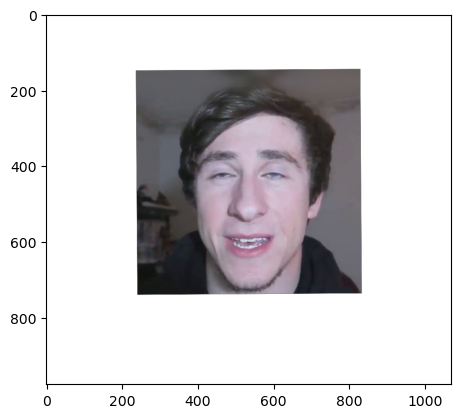

In [ ]:
#plt.imshow(out)
# Convert 'out' to RGBA format if it's not already
if out.shape[2] == 3:  # BGR image
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGBA)

# Create a mask for the non-transparent pixels
non_transparent_mask = out[:, :, 3] > 0

# Set the alpha channel to 0 for the transparent pixels
out[~non_transparent_mask, 3] = 0

# Display the result using matplotlib
print(out.shape)
plt.imshow(out)

(1068, 976) 177 (976, 1068, 4)


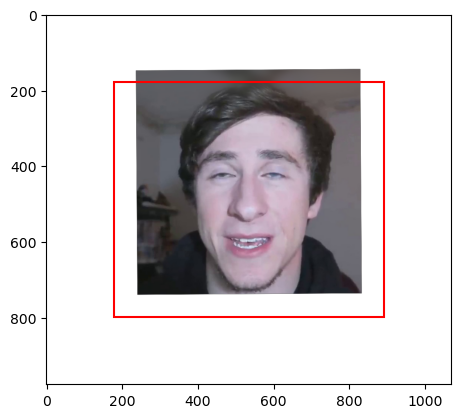

In [ ]:
from matplotlib.patches import Rectangle

pil_out = Image.fromarray(out)
#h, w = pil_out.size
print(pil_out.size, pad[0], out.shape)
h,w,_ = out.shape
plt.imshow(out)
plt.gca().add_patch(Rectangle((pad[0],pad[0]), w-2*pad[0], h-2*pad[0],linewidth=1.5,edgecolor='r',facecolor='none'))
#draw_bounding_box(pil_out, output_pts)

(714, 622, 4)


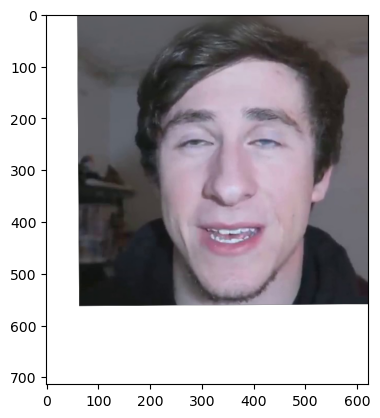

In [ ]:
cv2_crop = out[pad[0]:w-pad[0], pad[0]:h-pad[0]]
print(cv2_crop.shape)
plt.imshow(cv2_crop)

In [ ]:
# pil_crop = pil_out.crop((pad[0], pad[0], w-pad[0], h-pad[0]))
# print(pil_crop.size)
# pil_crop

## my work starts here

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt


In [58]:
bk_org_cv2 = np.array(img_list[0])
bk_org_cv2 = cv2.cvtColor(bk_org_cv2, cv2.COLOR_BGR2RGBA)

# make float versions

large_image = bk_org_cv2 /255.0
small_image_with_alpha = cv2_crop/255.0

# bk_org_cv2.shape, cv2_crop.shape #((720, 1280, 4), (714, 622, 4))

# #working settings 
# mask = (cv2_crop[:,:,3] == 0)+0 /1.0 # has 1's in padded region
# mask = np.expand_dims(mask,axis = 2)
# inv_mask = 1 -mask


#testing settings  ; Reducing white borders
inv_mask = (cv2_crop[:,:,3] == 255)+0 /1.0 # has 1's in padded region
inv_mask = np.expand_dims(inv_mask,axis = 2)
mask = 1 -inv_mask

# Extract the alpha channel from the smaller image
small_alpha = small_image_with_alpha[:, :, 3]

# Calculate the inverted alpha channel
inverted_alpha = 1 - (small_alpha / 255.0)

# Resize the smaller image to match the region you want to paste it onto
# (use cv2.resize or any other resizing method)

# Calculate the position to paste the smaller image onto the larger image
x_position = crop[0]
y_position = crop[1]

small_height, small_width, _ = small_image_with_alpha.shape


# removing "edited image region" ; making place for new commer
large_image[y_position:y_position + small_height, x_position:x_position + small_width, :]*= mask

# x_position -=10
# y_position -=1

large_image[y_position:y_position + small_height, x_position:x_position + small_width, :]+= small_image_with_alpha
plt.imshow(large_image)


NameError: name 'img_list' is not defined

Video Processing


In [59]:
import os
import dlib
from PIL import Image

after_drag_dir = '/home/bean/DragVideo/Data_store/data/exp_2_man/resutls_from_7/after_drag'

# Get the list of image files in the input directory
image_files = [f for f in os.listdir(after_drag_dir) if f.lower().endswith(('.jpg', '.png'))]

after_drag_img = []
# Iterate through all image files in the input directory
for filename in image_files:
    img_path = os.path.join(after_drag_dir, filename)

    print(filename)
    # Read the original image using PIL
    after_drag_image = Image.open(img_path)
    after_drag_img.append(after_drag_image)


FileNotFoundError: [Errno 2] No such file or directory: '/home/bean/DragVideo/Data_store/data/exp_2_man/resutls_from_7/after_drag'

In [ ]:
import os
import dlib
from PIL import Image

# Define the paths and constants
IMAGE_SIZE = 1024
dlib_predictor_path = '/home/bean/DragVideo/PTI/pretrained_models/align.dat'
input_directory = '/home/bean/DragVideo/Data_store/data/exp_2_man/raw_img_afterdrag'
#output_directory = '/path/to/your/output/directory'

# Load the dlib predictor
predictor = dlib.shape_predictor(dlib_predictor_path)

# Lists to store the variables and original images
aligned_images = []
original_images = []
crops = []
pads = []
img_crop = []
file_names = []
Quad = []
#org_crop_img = []

# Get the list of image files in the input directory
image_files = [f for f in os.listdir(input_directory) if f.lower().endswith(('.jpg', '.png'))]

# Iterate through all image files in the input directory
for filename in image_files:
    img_path = os.path.join(input_directory, filename)

    print(filename)
    # Read the original image using PIL
    original_image = Image.open(img_path)
    original_images.append(original_image)

    # Process each image using the align_face function
    aligned_image, crop, pad, img_list, quad = align_face(filepath=img_path, predictor=predictor, output_size=IMAGE_SIZE)

    # Append the results to the respective lists
    aligned_images.append(aligned_image)
    crops.append(crop)
    pads.append(pad)
    img_crop.append(img_list)
    file_names.append(filename)
    Quad.append(quad)


113.jpg
original (1280, 720)
after shrink (1280, 720)
crop (722, 640) 
 (270, 0, 992, 640)


KeyboardInterrupt: 

In [ ]:
# Sort all lists by ascending order of filenames
sorted_indices = sorted(range(len(file_names)), key=lambda k: file_names[k])
file_names = [file_names[i] for i in sorted_indices]
aligned_images = [aligned_images[i] for i in sorted_indices]
original_images = [original_images[i] for i in sorted_indices]
crops = [crops[i] for i in sorted_indices]
pads = [pads[i] for i in sorted_indices]
img_crop = [img_crop[i] for i in sorted_indices]
Quad = [Quad[i] for i in sorted_indices]
after_drag_img = [after_drag_img[i] for i in sorted_indices]

In [ ]:
transform_out = []

for i in range(len(aligned_images)):
# Main function to change 
# reverse transform

    import cv2

    crop_img = img_crop[i][-1]
    full_img = img_crop[i][2]

    org_size = full_img.size
    crop_size = crop_img.size
    print(org_size, crop_size)
    #crop_img.show()
    #full_img.show()

    full_img = np.array(full_img)
    full_img = cv2.cvtColor(full_img, cv2.COLOR_RGB2RGBA)

    crop_img = np.array(crop_img)
    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2RGBA)

    #pil_image = PIL.Image.open(crop_size).convert('RGB')
    # crop_img = np.array(crop_img)
    # # Convert RGB to BGR
    # crop_img = crop_img[:, :, ::-1].copy()

    # crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2RGBA)

    # Then assign the mask to the last channel of the image
    #rgba[:, :, 3] = alpha_data
    # points = [[crop[0], crop[1]],
    #              [crop[0], crop[3]],
    #              [crop[2], crop[3]],
    #              [crop[2], crop[1]]]

    # print(crop_size[0])
    # print(org_size)
    pt_A = [0, 0]
    pt_B = [0, crop_size[0]]
    pt_C = [crop_size[0], crop_size[0]]
    pt_D = [crop_size[0], 0]

    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])

    output_pts = np.float32((Quad[i][0],
                            Quad[i][1],
                            Quad[i][2],
                            Quad[i][3]))
    #print('input:', input_pts,'\n output:', output_pts)

    #H,W = org_size[:2]
    # H, W = 578, 456

    #output_pts = np.float32(([0, 0],
                        # [0 ,H],
                        # [W, H],
                        # [W, 0]))

    # output_pts = np.float32(([456, 0],
    #                     [456, 570],
    #                     [888, 570],
    #                     [888, 0]))

    #output_pts = np.float32((org_size[0], [0,100], [50,150], [150,0]))
    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    #print(M.shape)
    #the canvas size is (width, height) format

    out = cv2.warpPerspective(crop_img,M,(org_size[0], org_size[1]),flags=cv2.INTER_LINEAR)
    #print(out.shape)
    #plt.imshow(full_img)
    #plt.imshow(out)
    transform_out.append(out)

(1092, 1001) (1024, 1024)
(1090, 999) (1024, 1024)
(1092, 1000) (1024, 1024)
(1091, 999) (1024, 1024)
(1097, 1002) (1024, 1024)
(1088, 997) (1024, 1024)
(1090, 998) (1024, 1024)
(1081, 994) (1024, 1024)
(1085, 997) (1024, 1024)
(1074, 992) (1024, 1024)
(1082, 997) (1024, 1024)
(1073, 992) (1024, 1024)
(1074, 992) (1024, 1024)
(1076, 994) (1024, 1024)
(1085, 1000) (1024, 1024)
(1095, 1008) (1024, 1024)
(1095, 1008) (1024, 1024)
(1096, 1009) (1024, 1024)
(1093, 1010) (1024, 1024)
(1063, 994) (1024, 1024)
(1036, 981) (1024, 1024)
(1076, 1001) (1024, 1024)
(1044, 987) (1024, 1024)
(1037, 983) (1024, 1024)


In [ ]:
transform_out[0].shape, pads[0]

((976, 1068, 4), array([177, 177, 177, 177]))

In [ ]:
inv_crops = []
for j in range(len(pads)):
    h,w,_ = transform_out[j].shape
    #cv2_crop = transform_out[j][pads[j][0]:w-pads[j][0], pads[j][0]:h-pads[j][0]]
    #assuming pad is only below
    cv2_crop = transform_out[j][pads[j][0]: min(pads[j][0]+720,w-pads[j][0]), pads[j][0]:h-pads[j][0]]

    
    inv_crops.append(cv2_crop)

In [ ]:
post_video_frames_org = []
for i in range(len(inv_crops)):
    
    bk_org_cv2 = np.array(img_crop[i][0])
    bk_org_cv2 = cv2.cvtColor(bk_org_cv2, cv2.COLOR_BGR2RGBA)
    print(bk_org_cv2.shape, inv_crops[i].shape)
    # make float versions

    large_image = bk_org_cv2 /255.0
    small_image_with_alpha = inv_crops[i]/255.0

    # bk_org_cv2.shape, cv2_crop.shape #((720, 1280, 4), (714, 622, 4))

    # #working settings 
    # mask = (cv2_crop[:,:,3] == 0)+0 /1.0 # has 1's in padded region
    # mask = np.expand_dims(mask,axis = 2)
    # inv_mask = 1 -mask


    #testing settings  ; Reducing white borders
    inv_mask = (inv_crops[i][:,:,3] == 255)+0 /1.0 # has 1's in padded region
    inv_mask = np.expand_dims(inv_mask,axis = 2)
    mask = 1 -inv_mask

    # Extract the alpha channel from the smaller image
    small_alpha = small_image_with_alpha[:, :, 3]

    # Calculate the inverted alpha channel
    inverted_alpha = 1 - (small_alpha / 255.0)

    # Resize the smaller image to match the region you want to paste it onto
    # (use cv2.resize or any other resizing method)

    # Calculate the position to paste the smaller image onto the larger image
    x_position = crops[i][0]
    y_position = crops[i][1]

    small_height, small_width, _ = small_image_with_alpha.shape

    # removing "edited image region" ; making place for new commer
    print(mask.shape)
    

    large_image[y_position:y_position + small_height, x_position:x_position + small_width, :]*= mask

    # x_position -=10
    # y_position -=1

    large_image[y_position:y_position + small_height, x_position:x_position + small_width, :]+= small_image_with_alpha

    post_video_frames_org.append(large_image)
    #plt.imshow(large_image)

(720, 1280, 4) (720, 639, 4)
(720, 639, 1)
(720, 1280, 4) (720, 639, 4)
(720, 639, 1)
(720, 1280, 4) (720, 640, 4)
(720, 640, 1)
(720, 1280, 4) (720, 641, 4)
(720, 641, 1)
(720, 1280, 4) (720, 644, 4)
(720, 644, 1)
(720, 1280, 4) (720, 641, 4)
(720, 641, 1)
(720, 1280, 4) (720, 642, 4)
(720, 642, 1)
(720, 1280, 4) (720, 640, 4)
(720, 640, 1)
(720, 1280, 4) (720, 641, 4)
(720, 641, 1)
(720, 1280, 4) (720, 638, 4)
(720, 638, 1)
(720, 1280, 4) (720, 641, 4)
(720, 641, 1)
(720, 1280, 4) (719, 638, 4)
(719, 638, 1)
(720, 1280, 4) (720, 638, 4)
(720, 638, 1)
(720, 1280, 4) (720, 640, 4)
(720, 640, 1)
(720, 1280, 4) (720, 642, 4)
(720, 642, 1)
(720, 1280, 4) (720, 646, 4)
(720, 646, 1)
(720, 1280, 4) (720, 646, 4)
(720, 646, 1)
(720, 1280, 4) (720, 647, 4)
(720, 647, 1)
(720, 1280, 4) (720, 650, 4)
(720, 650, 1)
(720, 1280, 4) (711, 642, 4)
(711, 642, 1)
(720, 1280, 4) (692, 637, 4)
(692, 637, 1)
(720, 1280, 4) (718, 643, 4)
(718, 643, 1)
(720, 1280, 4) (700, 643, 4)
(700, 643, 1)
(720, 1280,

In [ ]:

# Your lists of cv2 images
list1 = post_video_frames_org  # List of cv2 images
list2 = post_video_frames  # List of cv2 images

# Create a figure and axis
fig, axes = plt.subplots(len(list1), 2, figsize=(10, 10))

# Iterate over each index and display images side by side
for idx, (img1, img2) in enumerate(zip(list1, list2)):
    plt.imshow(cimg1)
    axes[idx, 0].axis('off')
    axes[idx, 1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
for i,image in enumerate(post_video_frames):
    plt.imsave('output/'+file_names[i],image.clip(0,1))
    # plt.show()

In [ ]:
current_path = "/home/bean/DragVideo/"
os.chdir(current_path)
os.mkdir('output')

In [ ]:
file_names

['100.jpg',
 '101.jpg',
 '102.jpg',
 '103.jpg',
 '104.jpg',
 '105.jpg',
 '106.jpg',
 '107.jpg',
 '108.jpg',
 '109.jpg',
 '110.jpg',
 '111.jpg',
 '112.jpg',
 '113.jpg',
 '114.jpg',
 '115.jpg',
 '116.jpg',
 '117.jpg',
 '118.jpg',
 '119.jpg',
 '120.jpg',
 '121.jpg',
 '122.jpg',
 '123.jpg']

In [ ]:
for i,img in enumerate(post_video_frames):
    # pass
    cv2.imwrite('output/' + file_names[i],img)

In [ ]:
post_video_frames[0].shape

(720, 1280, 4)

In [ ]:
import cv2

# List of OpenCV image arrays
image_array_list = post_video_frames  # Your list of image arrays here
image_array_list = [img_array.astype(np.uint8) for img_array in image_array_list]
# Define the output video file name
#output_video_filename = 'output_video.mp4'

# Get the dimensions of the first image in the list
height, width, layers = image_array_list[0].shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change the codec as needed
out = cv2.VideoWriter('/home/bean/DragVideo/Data_store/data/video_inv_test.mp4', fourcc, 30, (width, height))

# Loop through the image array list and write each frame to the video
for img_array in image_array_list:
    out.write(img_array)

# Release the VideoWriter
out.release()

print(f"Video saved ")

Video saved 


In [ ]:
# imports 
import numpy as np
import PIL 
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt

    
#===============================================
# make GIF 
#===============================================
def make_gif(images, fname, duration=5, is_pil=True):
    import moviepy.editor as mpy
    
    def make_frame(t):
        try:
            x = images[int(len(images)/duration*t)]
        except:
            x = images[-1]
        
        # if true_image:
        #     return x.astype(np.uint8)
        # else:
        #     return ((x+1)/2*255).astype(np.uint8)
        
        # pil image to numpy array
        x = np.asarray(x)
        return x.astype(np.uint8)
        
        

    
    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.write_gif(fname, fps = len(images) / duration)
    

def gif_from_folder(folder_path,gif_path,
                    duration=2, is_pil=True):
    image_dir = folder_path
    image_list = os.listdir(image_dir)
    image_list.sort()
    image_list = [os.path.join(image_dir, image) for image in image_list]
    images = [Image.open(image) for image in image_list]
    make_gif(images, gif_path, duration=duration, is_pil=is_pil)
    
#===============================================
# make video (avi)
#===============================================

def make_video(path,
                video_name='test_video',
                fps=24,
                ext=None): 
    """Make a video from a folder of images.
    stores the video (.avi) in same folder as the images

    Args:
        path (str): Path to folder of images.
        fps (int): Frames per second of video. default=24
    """
    if ext is None:
        images = [img for img in os.listdir(path) ]
    else:
        images = [img for img in os.listdir(path) if img.endswith("." + ext)]
        
    images = sorted(images, key=lambda x: int(x.split(".")[0]))
    frame = cv2.imread(os.path.join(path, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(
        os.path.join(path, f"{video_name}.avi"),
        cv2.VideoWriter_fourcc(*"DIVX"),
        fps,
        (width, height),
    )

    for image in images:
        video.write(cv2.imread(os.path.join(path, image)))

    cv2.destroyAllWindows()
    video.release()


# ==============================================
# Extract frames from video
# ==============================================
# video_path = "alien_girl.mp4"
# output_path = "frames/"

def extract_frames(video_path, output_path):
    # imports 
    import cv2
    import os

    # Read the video from specified path
    cam = cv2.VideoCapture(video_path)
    # extract frames
    try:
        # creating a folder named data
        if not os.path.exists(output_path):
            os.makedirs(output_path)
    # if not created then raise error
    except OSError:
        print ('Error: Creating directory of data')
    # frame
    currentframe = 0
    while(True):
        # reading from frame
        ret,frame = cam.read()
        if ret:
            # if video is still left continue creating images
            name = os.path.join(output_path, str(currentframe) + '.jpg')
            print ('Creating...' + name)
            # writing the extracted images
            cv2.imwrite(name, frame)
            # increasing counter so that it will
            # show how many frames are created
            currentframe += 1
        else:
            break


# ==============================================
# video side by side
# ==============================================

def video_side_by_side(video1_path, video2_path, output_path):
    # imports 
    import cv2
    import os

    # Read the video from specified path
    cam1 = cv2.VideoCapture(video1_path)
    cam2 = cv2.VideoCapture(video2_path)
    # extract frames
    try:
        # creating a folder named data
        if not os.path.exists(output_path):
            os.makedirs(output_path)
    # if not created then raise error
    except OSError:
        print ('Error: Creating directory of data')
    # frame
    currentframe = 0
    while(True):
        # reading from frame
        ret1,frame1 = cam1.read()
        ret2,frame2 = cam2.read()
        if ret1 and ret2:
            # if video is still left continue creating images
            name = os.path.join(output_path, str(currentframe) + '.jpg')
            print ('Creating...' + name)
            # writing the extracted images
            frame = np.concatenate((frame1, frame2), axis=1)
            cv2.imwrite(name, frame)
            # increasing counter so that it will
            # show how many frames are created
            currentframe += 1
        else:
            break


# ==============================================
# avi to mp4
# ==============================================

def avi2mp4(avi_path=None):
    """ 
    ffmped must be installed
    sudo apt-get install ffmpeg

    """
    assert avi_path is not None, "avi_path is None"


    import os
    import subprocess
   
    
    # get video name
    video_name = os.path.basename(avi_path).split('.')[0]
    # get output path
    output_path = os.path.dirname(avi_path)
    # get output name
    output_name = video_name + '.mp4'
    # get output path
    output_path = os.path.join(output_path, output_name)
    # convert
    subprocess.call(['ffmpeg', '-i', avi_path, output_path])
    # delete avi file
    # os.remove(avi_path)
    print("avi file deleted")
    return output_path


In [ ]:
drag_path = "/home/bean/DragVideo/DragGAN"
import os 
os.chdir(drag_path)

print(os.getcwd())

path = '/home/bean/DragVideo/output'
# from util.video_utils import make_video


make_video(path,
                video_name='test_video_fps_20',
                fps=20,
                ext=None)
    # """Make a video from a folder of images.
    


In [ ]:
avi2mp4(avi_path="/home/bean/DragVideo/output/test_video.avi")

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

KeyboardInterrupt: 